#### This notebook calculates the probablities of each state of antecedent soil mositure given a rainfall with know return period is happened
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import rasterio
import textwrap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.font_manager as fm
import random
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
#import py3dep
import pyproj
from pyproj import CRS
import os
import warnings
import subprocess
from tqdm import tqdm
from watermark import watermark
import datetime

# Load data

# COOP:300042	ALBANY INTERNATIONAL AIRPORT NY US

In [ ]:
path= r"D:\culvert repo\data\15_min_rainfall\4079342.csv"
rain= pd.read_csv(path)
rain.head()path= r"D:\culvert repo\data\15_min_rainfall\4079342.csv"
rain= pd.read_csv(path)
rain.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement Flag,Quality Flag
0,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75,-73.8,19480501 01:00,0.00,g,
1,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75,-73.8,19480507 12:00,0.01,,
2,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75,-73.8,19480507 13:00,0.04,,
3,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75,-73.8,19480507 14:00,0.10,,
4,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75,-73.8,19480507 15:00,0.12,,


In [25]:
rain['DATE'] = pd.to_datetime(rain['DATE'])
rain['HPCP'] = rain['HPCP'].replace(999.99, np.nan)
rain['HPCP'].describe() #inch

count    58723.000000
mean         0.041483
std          0.075770
min          0.000000
25%          0.010000
50%          0.020000
75%          0.050000
max          2.190000
Name: HPCP, dtype: float64

In [29]:
# Step 2: Sort and set Date as index
rain = rain.sort_values('DATE').set_index('DATE')

# Step 3: Calculate 5-day cumulative rainfall prior to each timestep (excluding current timestep)
rain['5_day_total'] = rain['HPCP'].rolling(window=24*5).sum().shift(1)

# Step 4: Drop rows where 5-day history wasn't available
rain = rain.dropna(subset=['5_day_total'])

# Optional: Reset index if needed
rain = rain.reset_index()

In [30]:
rain

,DATE,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,HPCP,Measurement Flag,Quality Flag,5_day_total
0,1948-06-08 01:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.01,,,6.08
1,1948-06-08 03:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.02,,,6.08
2,1948-06-08 04:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.01,,,6.06
3,1948-06-08 15:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.05,,,5.97
4,1948-06-09 03:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.01,,,5.90
...,...,...,...,...,...,...,...,...,...,...
58002,2013-12-31 15:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,85.4,42.74722,-73.79913,0.00,T,,2.81
58003,2013-12-31 16:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,85.4,42.74722,-73.79913,0.00,T,,2.77
58004,2013-12-31 17:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,85.4,42.74722,-73.79913,0.00,T,,2.75
58005,2013-12-31 18:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,85.4,42.74722,-73.79913,0.01,,,2.72


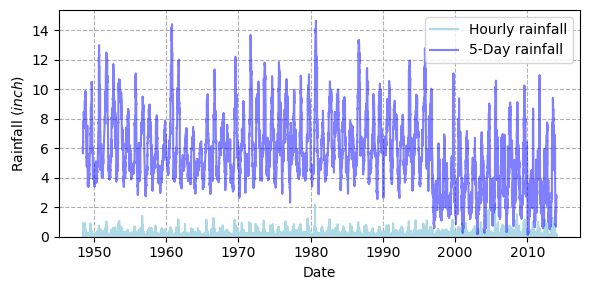

In [72]:
# Plotting
plt.figure(figsize=(6, 3))
plt.plot(rain['DATE'], rain['HPCP'], label='Hourly rainfall', color='lightblue')
plt.plot(rain['DATE'], rain['5_day_total'], label='5-Day rainfall', color='blue',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Rainfall ($inch$)')
#plt.title('Hourly Rainfall and 5-Day Average')
plt.ylim(0,)
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Add month and day columns
rain['month'] = rain['DATE'].dt.month
rain['day'] = rain['DATE'].dt.day

# Identify growing vs dormant season in NYS
def classify_season(month, day):
    if 5 <= month <= 10:  # May to October
        return 'growing'
    else:
        return 'dormant'

rain['season'] = rain.apply(lambda row: classify_season(row['month'], row['day']), axis=1)

# Define a function to classify AMC
def classify_amc(row): # thershold come from SCS 1972 table 4.2 p 4.12
    rain_5d = row['5_day_total']
    season = row['season']
    
    if season == 'growing':
        if rain_5d < 1.4:
            return 'I'
        elif rain_5d <= 2.1:
            return 'II'
        else:
            return 'III'
    else:  # dormant
        if rain_5d < 0.5:
            return 'I'
        elif rain_5d <= 1.1:
            return 'II'
        else:
            return 'III'

# Apply AMC classification
rain['AMC'] = rain.apply(classify_amc, axis=1)

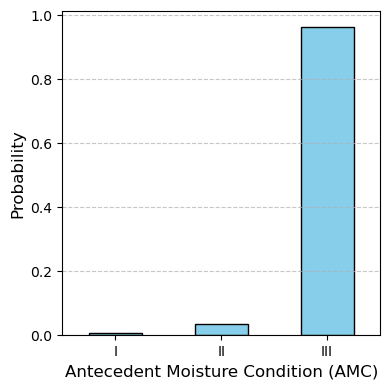

In [55]:
# Count AMC occurrences and convert to probability
amc_counts = rain['AMC'].value_counts(normalize=True).sort_index()  # I, II, III
# Plot
plt.figure(figsize=(4, 4))
amc_counts.plot(kind='bar', color='skyblue', edgecolor='black')
# Labels and formatting
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Antecedent Moisture Condition (AMC)', fontsize=12)
#plt.title('Probability of Each AMC State', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

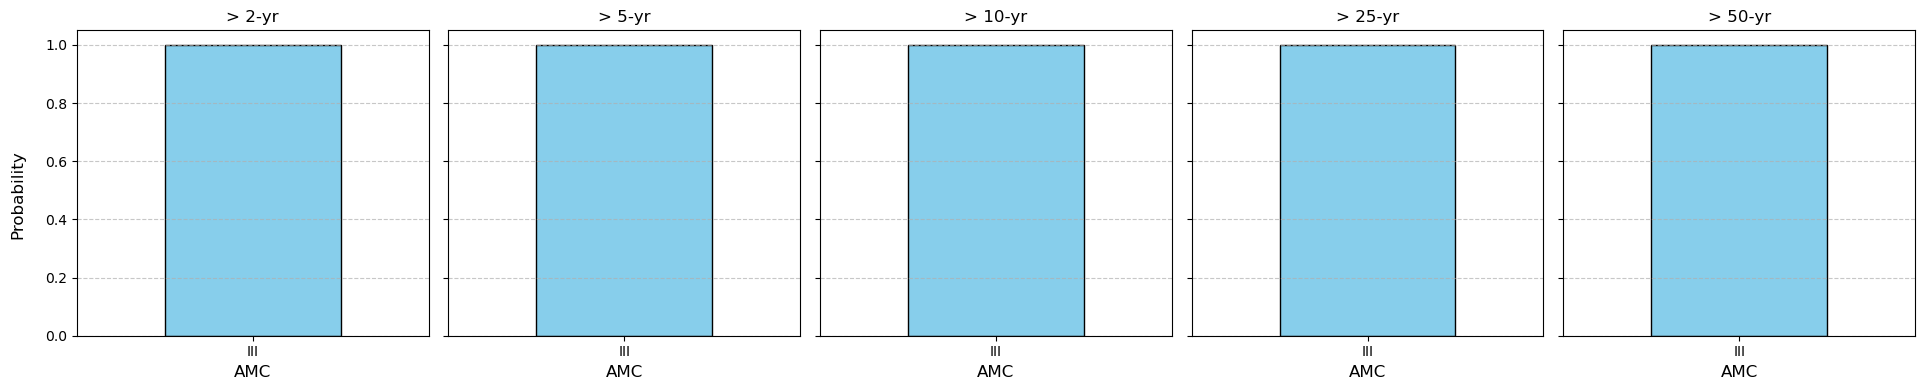

In [60]:
# Define 1-hour rainfall return period thresholds in inches
rainfall_thresholds = {2: 0.944, 5: 1.29, 10: 1.56, 25: 1.91, 50: 2.16}

# Create subplots
fig, axes = plt.subplots(1, len(rainfall_thresholds), figsize=(4 * len(rainfall_thresholds), 4), sharey=True)

# Loop through return periods and axes
for ax, (rp, threshold) in zip(axes, rainfall_thresholds.items()):
    rain_exceed = rain[rain['HPCP'] > threshold]
    amc_counts = rain_exceed['AMC'].value_counts(normalize=True).sort_index()
    amc_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'> {rp}-yr', fontsize=12)
    ax.set_xlabel('AMC', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xticklabels(amc_counts.index, rotation=0)

# Shared y-axis label
fig.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()


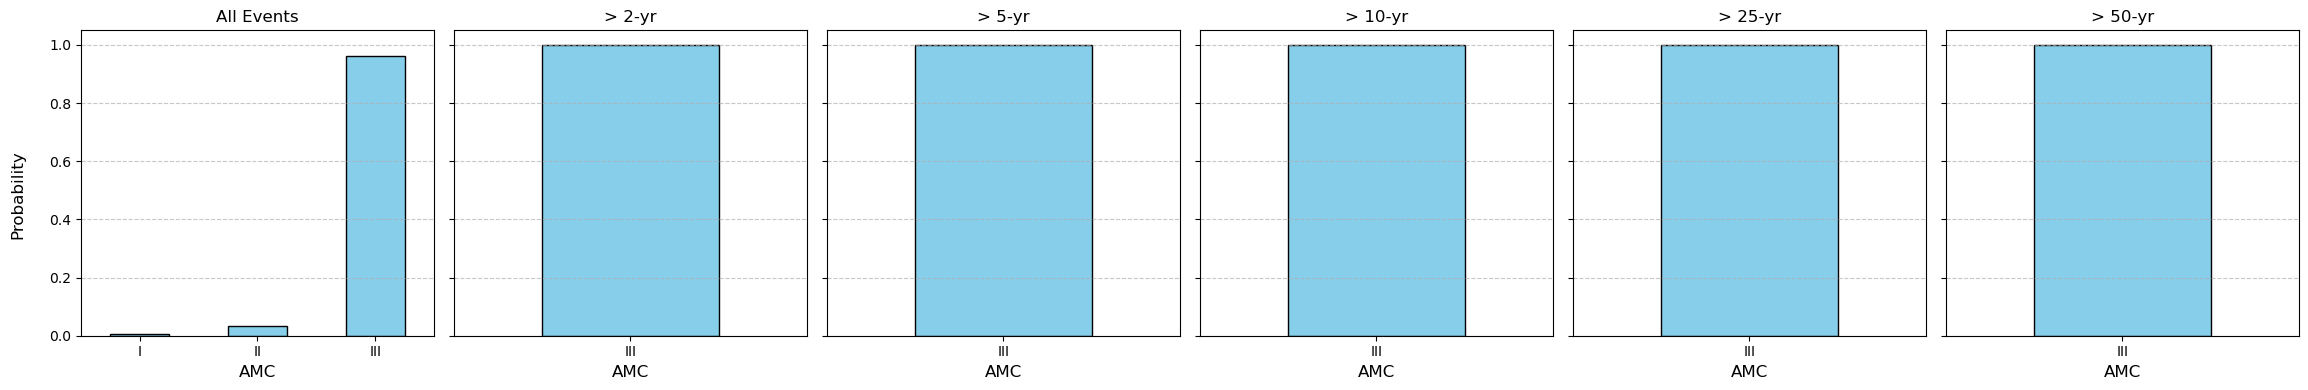

In [61]:
# Define 1-hour rainfall return period thresholds in inches
rainfall_thresholds = {2: 0.944, 5: 1.29, 10: 1.56, 25: 1.91, 50: 2.16}

# Total number of subplots (1 for overall + number of return periods)
n_subplots = 1 + len(rainfall_thresholds)

# Create subplots
fig, axes = plt.subplots(1, n_subplots, figsize=(4 * n_subplots, 4), sharey=True)

# --- Plot 1: Overall AMC probability ---
amc_counts_all = rain['AMC'].value_counts(normalize=True).sort_index()
amc_counts_all.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('All Events', fontsize=12)
axes[0].set_xlabel('AMC', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_xticklabels(amc_counts_all.index, rotation=0)

# --- Plot 2 to N: Threshold-based AMC probability ---
for ax, (rp, threshold) in zip(axes[1:], rainfall_thresholds.items()):
    rain_exceed = rain[rain['HPCP'] > threshold]
    amc_counts = rain_exceed['AMC'].value_counts(normalize=True).sort_index()
    amc_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'> {rp}-yr', fontsize=12)
    ax.set_xlabel('AMC', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xticklabels(amc_counts.index, rotation=0)

# Shared y-axis label
fig.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

In [82]:
def analyze_rainfall_amc(file_path, rainfall_thresholds):
    """
    Load rainfall data, classify AMC using SCS criteria, and plot AMC distributions
    overall and for rainfall events exceeding given return period thresholds.

    Parameters:
        file_path (str): Path to the rainfall CSV file.
        rainfall_thresholds (dict): Return period thresholds in inches. 
                                    Example: {2: 0.944, 5: 1.29, 10: 1.56}
    """
    # --- Load and preprocess ---
    rain = pd.read_csv(file_path)
    rain['DATE'] = pd.to_datetime(rain['DATE'])
    rain['HPCP'] = rain['HPCP'].replace(999.99, np.nan)
    rain = rain.sort_values('DATE').set_index('DATE')
    rain['5_day_total'] = rain['HPCP'].rolling(window=24*5).sum().shift(1)
    rain = rain.dropna(subset=['5_day_total']).reset_index()

    # --- Add season classification ---
    rain['month'] = rain['DATE'].dt.month
    rain['day'] = rain['DATE'].dt.day
    rain['season'] = rain.apply(
        lambda row: 'growing' if 5 <= row['month'] <= 10 else 'dormant', axis=1
    )

    # --- Classify AMC using SCS thresholds ---
    def classify_amc(row):
        rain_5d = row['5_day_total']
        if row['season'] == 'growing':
            if rain_5d < 1.4:
                return 'I'
            elif rain_5d <= 2.1:
                return 'II'
            else:
                return 'III'
        else:
            if rain_5d < 0.5:
                return 'I'
            elif rain_5d <= 1.1:
                return 'II'
            else:
                return 'III'

    rain['AMC'] = rain.apply(classify_amc, axis=1)

    # --- Plot rainfall and 5-day totals ---
    plt.figure(figsize=(6, 3))
    plt.plot(rain['DATE'], rain['HPCP'], label='Hourly rainfall', color='lightblue')
    plt.plot(rain['DATE'], rain['5_day_total'], label='5-Day total', color='blue', alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('Rainfall (inch)')
    plt.ylim(0,)
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- AMC probability plots ---
    n_subplots = 1 + len(rainfall_thresholds)
    fig, axes = plt.subplots(1, n_subplots, figsize=(4 * n_subplots, 4), sharey=True)

    # Overall AMC probability
    amc_counts_all = rain['AMC'].value_counts(normalize=True).sort_index()
    amc_counts_all.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title('All Events', fontsize=12)
    axes[0].set_xlabel('AMC', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].set_xticklabels(amc_counts_all.index, rotation=0)

    # AMC probabilities by return period
    for ax, (rp, threshold) in zip(axes[1:], rainfall_thresholds.items()):
        rain_exceed = rain[rain['HPCP'] > threshold]
        amc_counts = rain_exceed['AMC'].value_counts(normalize=True).sort_index()
        amc_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(f'> {rp}-yr', fontsize=12)
        ax.set_xlabel('AMC', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xticklabels(amc_counts.index, rotation=0)

    fig.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', fontsize=12)
    plt.tight_layout(rect=[0.05, 0, 1, 1])
    plt.show()

    return rain  # return DataFrame for further inspection or analysis

# COOP:300042	ALBANY INTERNATIONAL AIRPORT NY US

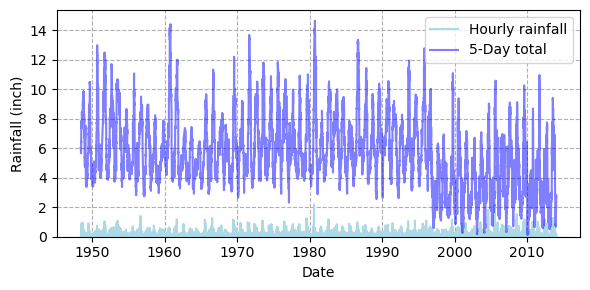

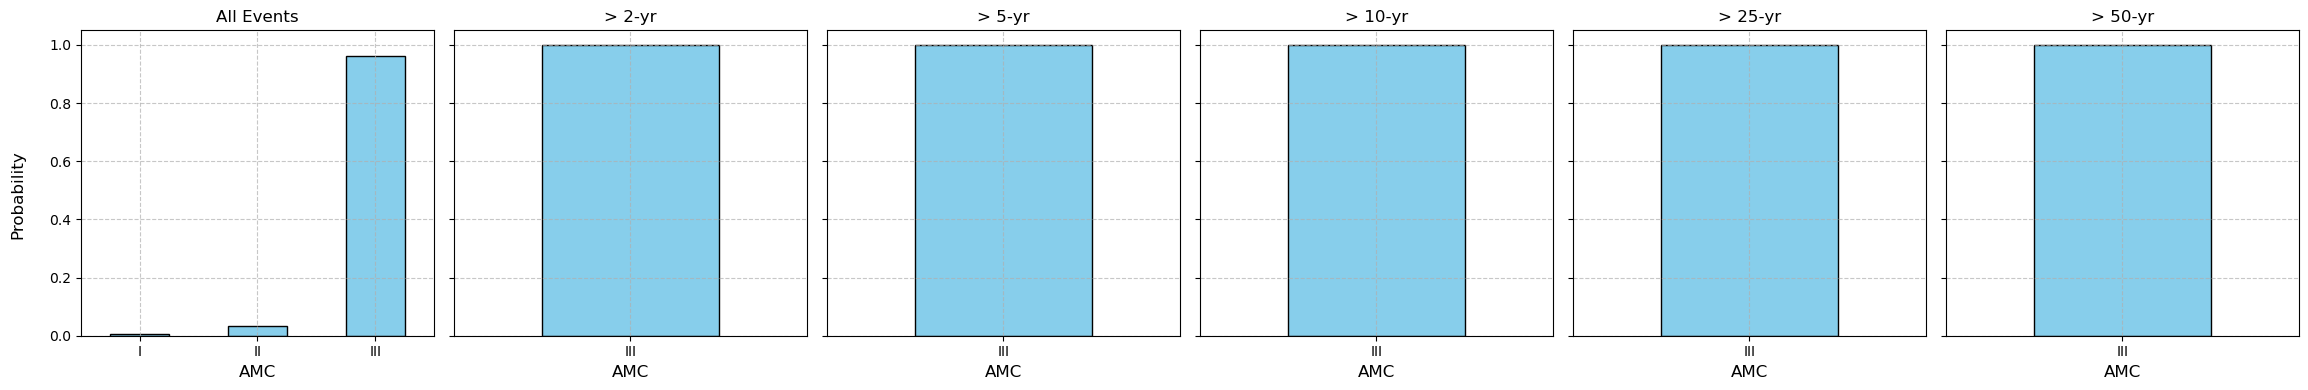

,DATE,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,HPCP,Measurement Flag,Quality Flag,5_day_total,month,day,season,AMC
0,1948-06-07 19:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.01,,,6.07,6,7,growing,III
1,1948-06-08 01:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.01,,,6.08,6,8,growing,III
2,1948-06-08 03:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.02,,,6.08,6,8,growing,III
3,1948-06-08 04:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.01,,,6.06,6,8,growing,III
4,1948-06-08 15:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,89.0,42.75000,-73.80000,0.05,,,5.97,6,8,growing,III
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58003,2013-12-31 15:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,85.4,42.74722,-73.79913,0.00,T,,2.81,12,31,dormant,III
58004,2013-12-31 16:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,85.4,42.74722,-73.79913,0.00,T,,2.77,12,31,dormant,III
58005,2013-12-31 17:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,85.4,42.74722,-73.79913,0.00,T,,2.75,12,31,dormant,III
58006,2013-12-31 18:00:00,COOP:300042,ALBANY INTERNATIONAL AIRPORT NY US,85.4,42.74722,-73.79913,0.01,,,2.72,12,31,dormant,III


In [89]:
thresholds = {
    2: 0.944,
    5: 1.29,
    10: 1.56,
    25: 1.91,
    50: 2.16
}

analyze_rainfall_amc(r"D:\culvert repo\data\15_min_rainfall\4079342.csv", thresholds)

# COOP:305801	NY CITY CENTRAL PARK NY US

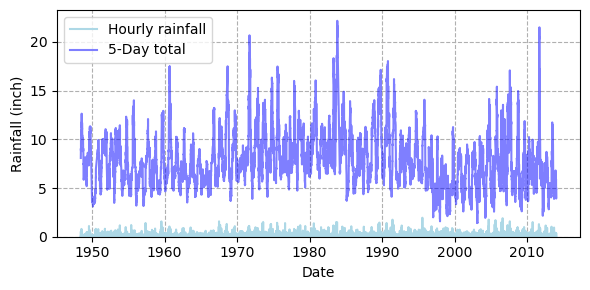

IndexError: index 0 is out of bounds for axis 0 with size 0

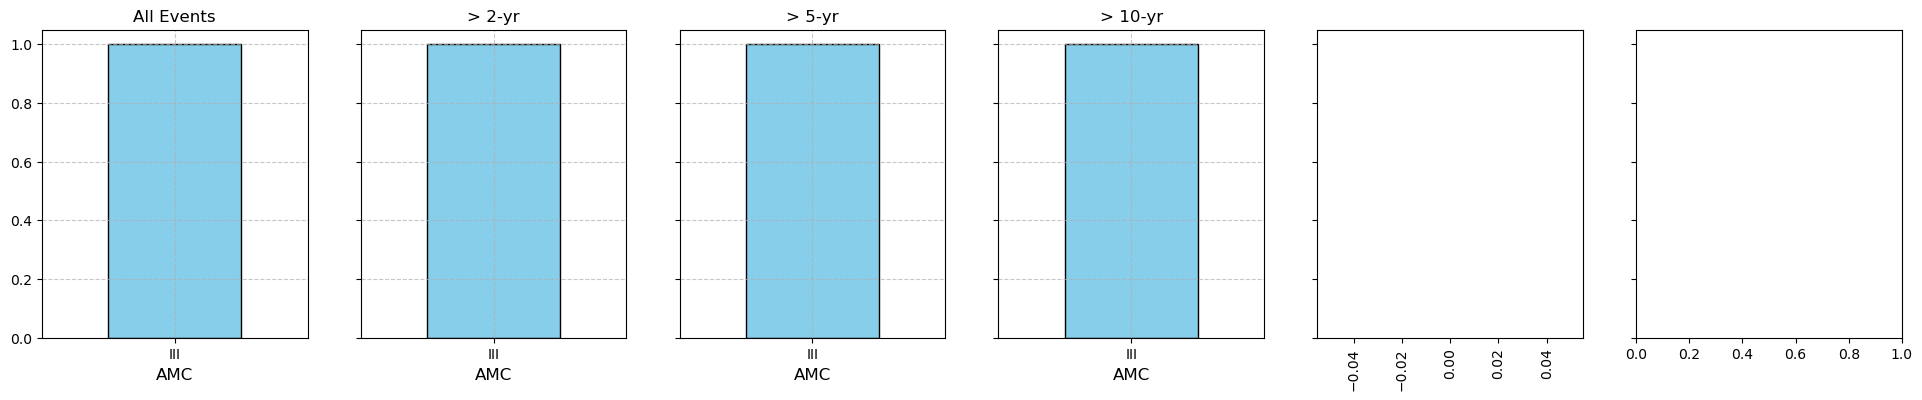

In [88]:
thresholds = {
    2: 1.17,
    5: 1.57,
    10: 1.87,
    25: 2.27,
    50: 2.56
}

analyze_rainfall_amc(r"D:\culvert repo\data\15_min_rainfall\4079955.csv", thresholds)

# 

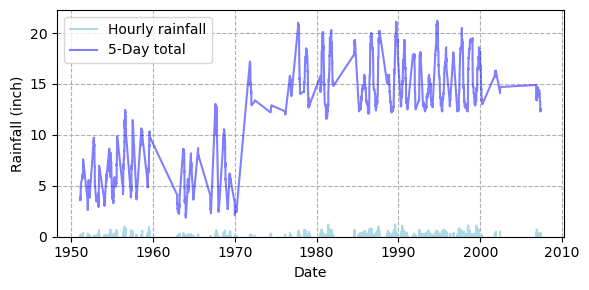

IndexError: index 0 is out of bounds for axis 0 with size 0

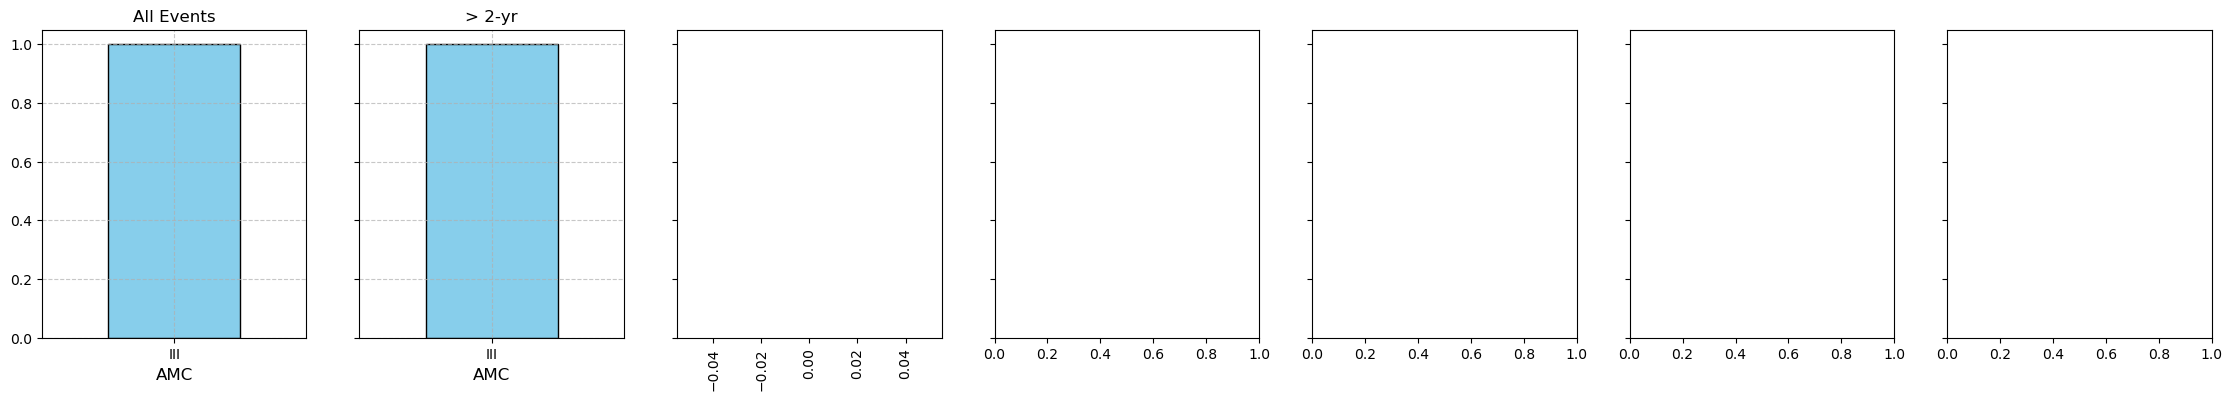

In [86]:

thresholds = {
    2: 0.938,
    5: 1.29,
    10: 1.56,
    25:1.92,
    50:2.18,
    100:2.46
}

analyze_rainfall_amc(r"D:\culvert repo\data\15_min_rainfall\4080015.csv", thresholds)